In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt


In [2]:
# Paso 1: Cargar el dataset
df = pd.read_csv('bitcoin_usd.csv', index_col='Unnamed: 0', parse_dates=True)
df.index.name = 'fecha'  # Renombrar el índice para que sea 'fecha'
df.reset_index(inplace=True)  # Convertir el índice en una columna

In [3]:
# Convertir la columna 'fecha' en tipo datetime y ordenar el dataframe
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values(by='fecha')

In [4]:
# Paso 2: Preparar los datos
data = df[['close_USD']].copy()

In [5]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [6]:
# Crear un dataset de secuencias
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [7]:
SEQ_LENGTH = 60  # Número de días para cada secuencia
X, y = create_sequences(scaled_data, SEQ_LENGTH)

In [8]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [9]:
# Paso 3: Construcción del modelo
model = Sequential()
model.add(GRU(16, activation='relu', input_shape=(SEQ_LENGTH, 1))) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\deyvi.caicedo\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Paso 4: Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0098 - val_loss: 0.0053
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.0446e-04 - val_loss: 6.8668e-04
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.9329e-04 - val_loss: 2.4853e-04
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.0996e-04 - val_loss: 1.1557e-04
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3634e-04 - val_loss: 3.7669e-05
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.0263e-05 - val_loss: 3.9785e-05
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1479e-04 - val_loss: 3.7806e-05
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2484e-04 - val_loss: 3.8484e-05


In [11]:
# Paso 5: Hacer predicciones
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


In [12]:
# Desnormalizar las predicciones y los datos de prueba
y_test_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), 1)), y_test], axis=1))[:, 1]
y_pred_inv = scaler.inverse_transform(np.concatenate([np.zeros((len(y_pred), 1)), y_pred], axis=1))[:, 1]

In [13]:
# Calcular métricas de evaluación
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)

In [14]:
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 52472287.777874604
Root Mean Squared Error (RMSE): 7243.7757956658625
Mean Absolute Error (MAE): 4462.676860730543


In [15]:
# Paso 6: Graficar resultados
plt.figure(figsize=(18, 12))


<Figure size 1800x1200 with 0 Axes>

<Figure size 1800x1200 with 0 Axes>

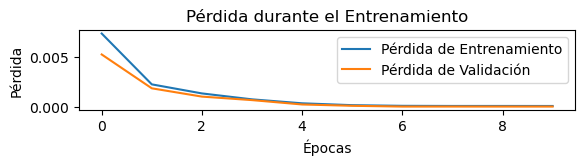

In [16]:
# Gráfico de la pérdida durante el entrenamiento
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

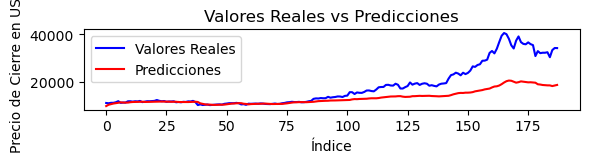

In [17]:
# Gráfico de las predicciones vs los valores reales
plt.subplot(4, 1, 2)
plt.plot(range(len(y_test_inv)), y_test_inv, label='Valores Reales', color='blue')
plt.plot(range(len(y_pred_inv)), y_pred_inv, label='Predicciones', color='red')
plt.title('Valores Reales vs Predicciones')
plt.xlabel('Índice')
plt.ylabel('Precio de Cierre en USD')
plt.legend()

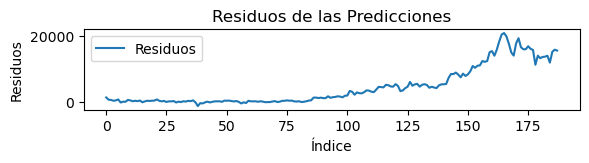

In [18]:
# Gráfico de los residuos
residuals = y_test_inv - y_pred_inv
plt.subplot(4, 1, 3)
plt.plot(residuals, label='Residuos')
plt.title('Residuos de las Predicciones')
plt.xlabel('Índice')
plt.ylabel('Residuos')
plt.legend()

In [19]:
# Gráfico de zoom: ventana de 5 días
start_index = 0  # Cambiar para ver una ventana diferente
end_index = 5  # Ajustar para el intervalo de 5 días

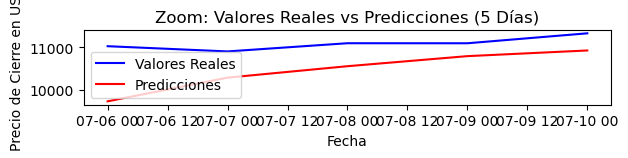

In [20]:
plt.subplot(4, 1, 4)
plt.plot(df['fecha'].iloc[SEQ_LENGTH+start_index:SEQ_LENGTH+end_index], y_test_inv[start_index:end_index], label='Valores Reales', color='blue')
plt.plot(df['fecha'].iloc[SEQ_LENGTH+start_index:SEQ_LENGTH+end_index], y_pred_inv[start_index:end_index], label='Predicciones', color='red')
plt.title('Zoom: Valores Reales vs Predicciones (5 Días)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre en USD')
plt.legend()
plt.tight_layout()
plt.show()
